# User Guide
[![View On GitHub](https://img.shields.io/badge/View_in_Github-grey?logo=github)](https://github.com/Qrlew/docs/blob/main/tutorials/user_guide.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Qrlew/docs/blob/main/tutorials/user_guide.ipynb)

[Qrlew](https://qrlew.github.io/) is an [open source library](https://github.com/Qrlew) that can turn SQL queries into their [differentially private (DP)](https://en.wikipedia.org/wiki/Differential_privacy) equivalent.
* It takes SQL – the universal language of small and big data analytics – as input, so there is no new language or API to learn.
* It returns DP SQL queries that can be executed at scale on any SQL datastore.
* The only required extra inputs are the *privacy unit* specification and privacy budget $(\varepsilon, \delta)$.

With [Qrlew](https://qrlew.github.io/) a *data owner* can receive SQL queries from an untrusted *data analyst*, turn them into DP equivalent, execute them and safely return the result to the *data analyst*.

This guide will cover several useful notions from [Qrlew](https://qrlew.github.io/):
* We will define a `Dataset` from a database connection.
* We will declare value ranges and unique constraints
* We will define a *privacy unit*.
* And we will run simple DP SQL queries.

We will also explore more advanced features:
* The support of several SQL dialects: PostgreSQL (default), MSSQL or BigQuery.
* The possibility to provide hints – data ranges, finite set of values or unicity constraints – to qrlew to improve the usefulness of the results.
* Privacy accounting compatibility with Google's popular Differential Privacy accounting: [dp_accounting](https://github.com/google/differential-privacy/tree/main/python/dp_accounting).
* The use of Synthetic Data to further improve the quality of the results.

## Define a Dataset

Let's define a `Dataset` object from a SQL conection.

We will first run a local postgresql database. You can connect to any Postgresql, MSSQL or BigQuery database.

In [1]:
%%capture
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql
!sudo service postgresql start
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'password'"
!pip install psycopg2
!pip install pyqrlew

Then we load a demo dataset.

In [2]:
from pyqrlew.io import PostgreSQL

database = PostgreSQL('postgres', 'postgres', 'password', 5432)
database.load_imdb()
engine = database.engine()

We can then build a `Dataset` object that can be used to parse queries into `Relation` objects that can be transformed into differentially private `Relation`s and rendered into SQL queries.

In [3]:
from pyqrlew import Dataset

source_dataset = Dataset.from_database('imdb', engine, 'imdb_ijs')

for relation in source_dataset.relations():
  print(relation)

(['imdb', 'imdb_ijs', 'actors'], <builtins.Relation object at 0x7f7eb67a2bd0>)
(['imdb', 'imdb_ijs', 'directors'], <builtins.Relation object at 0x7f7eb67a37b0>)
(['imdb', 'imdb_ijs', 'directors_genres'], <builtins.Relation object at 0x7f7eb67a24d0>)
(['imdb', 'imdb_ijs', 'movies'], <builtins.Relation object at 0x7f7eb67a3810>)
(['imdb', 'imdb_ijs', 'movies_directors'], <builtins.Relation object at 0x7f7eb67a3850>)
(['imdb', 'imdb_ijs', 'movies_genres'], <builtins.Relation object at 0x7f7eb67a3870>)
(['imdb', 'imdb_ijs', 'roles'], <builtins.Relation object at 0x7f7eb5e38a10>)


## Declare value ranges and unique constraints

In [4]:
bounded_dataset = source_dataset.imdb_ijs.movies.rank.with_range(0, 20)
bounded_dataset = bounded_dataset.imdb_ijs.actors.gender.with_possible_values(['M', 'F'])
dataset = (bounded_dataset
  .imdb_ijs.actors.id.with_unique_constraint()
  .imdb_ijs.directors.id.with_unique_constraint()
  .imdb_ijs.movies.id.with_unique_constraint())

## Display a graphical representation of the `Relation` objects

Tables are the most basic forms of `Relation`.

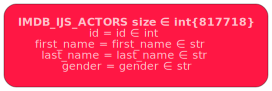

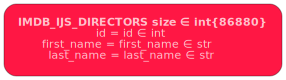

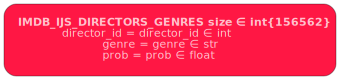

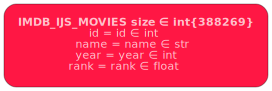

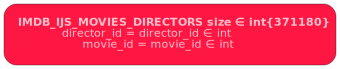

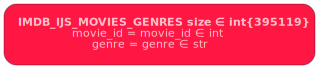

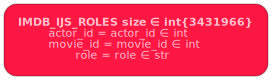

In [5]:
from graphviz import Source

for path, relation in source_dataset.relations():
  display(Source(relation.dot()))

Qrlew turns queries into composed `Relation` objects.

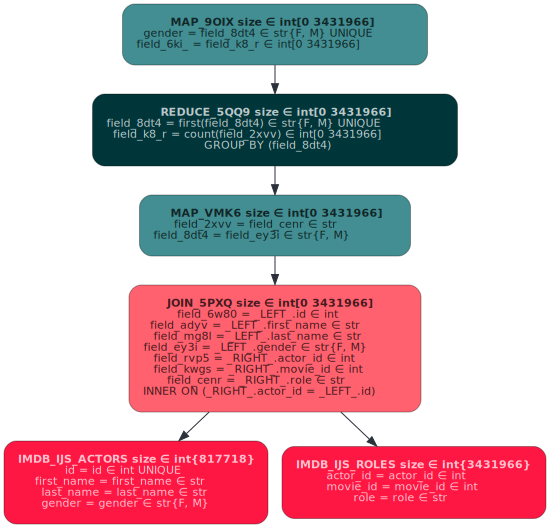

In [6]:
query = "SELECT gender, COUNT(role) FROM imdb_ijs.actors JOIN imdb_ijs.roles ON roles.actor_id=actors.id GROUP BY gender"
relation = dataset.relation(query)
display(Source(relation.dot()))

## Define a Privacy Unity



In [7]:
# Privacy unit definition
privacy_unit = [
    # The column `id` directly defines the privacy unit
    ("actors", [], "id"),
    ("directors", [], "id"),
    # The column `director_id` refers to the column `id` of table `directors`, the `id` of which defines the privacy unit
    ("directors_genres", [("director_id", "directors", "id")], "id"),
    ("movies_directors", [("director_id", "directors", "id")], "id"),
    # The column `actor_id` refers to the column `id` of table `actors`, the `id` of which defines the privacy unit
    ("roles", [("actor_id", "actors", "id")], "id"),
]
# Privacy paramers
budget = {"epsilon": 1.0, "delta": 1e-3}

## Run simple DP SQL queries

In [8]:
# We create a basic aggregation relation
query = "SELECT gender, COUNT(*) FROM imdb_ijs.actors GROUP BY gender"
relation = dataset.relation(query)
# The relation is turned into a DP equivalent
relation_with_dp_event = relation.rewrite_with_differential_privacy(
    dataset,
    privacy_unit,
    budget,
)
# Rewritten relation
dp_relation = relation_with_dp_event.relation()
dp_query = dp_relation.to_query()
print(dp_query)
# Privacy loss
dpe = relation_with_dp_event.dp_event()
print(dpe)

WITH "field_d4_o" ("field_d4_o") AS (SELECT * FROM (VALUES ('F'), ('M')) AS "field_d4_o" ("field_d4_o")), "map_o7od" ("_PRIVACY_UNIT_", "_PRIVACY_UNIT_WEIGHT_", "id", "first_name", "last_name", "gender") AS (SELECT MD5(CAST("id" AS TEXT)) AS "_PRIVACY_UNIT_", 1 AS "_PRIVACY_UNIT_WEIGHT_", "id" AS "id", "first_name" AS "first_name", "last_name" AS "last_name", "gender" AS "gender" FROM "imdb_ijs"."actors"), "map_q1hj" ("_PRIVACY_UNIT_", "_PRIVACY_UNIT_WEIGHT_", "field_n9r3", "field_d4_o") AS (SELECT "_PRIVACY_UNIT_" AS "_PRIVACY_UNIT_", "_PRIVACY_UNIT_WEIGHT_" AS "_PRIVACY_UNIT_WEIGHT_", 1 AS "field_n9r3", "gender" AS "field_d4_o" FROM "map_o7od"), "join_o8kk" ("field_d4_o", "_PRIVACY_UNIT_", "_PRIVACY_UNIT_WEIGHT_", "field_n9r3", "left__q8p1") AS (SELECT * FROM "field_d4_o" AS "_LEFT_" LEFT JOIN "map_q1hj" AS "_RIGHT_" ON ("_LEFT_"."field_d4_o") = ("_RIGHT_"."field_d4_o")), "map_niv7" ("field_d4_o", "_PRIVACY_UNIT_", "_PRIVACY_UNIT_WEIGHT_", "field_n9r3") AS (SELECT "field_d4_o" AS "fi

In [9]:
import pandas as pd

true_res = pd.read_sql(query, database.engine())
dp_res = pd.read_sql(dp_query, database.engine())

print('Result')
display(true_res.sort_values('gender'))

print('DP Result')
display(dp_res.sort_values('gender'))

Result


,gender,count
0,F,304412
1,M,513306


DP Result


,gender,field_34j2
1,F,304408
0,M,513305


## Run DP SQL queries with non-trivial Privacy Unit multiplicity

In [10]:
# We create a basic aggregation relation
query = "SELECT gender, COUNT(*) FROM imdb_ijs.actors JOIN imdb_ijs.roles ON roles.actor_id=actors.id GROUP BY gender"
relation = dataset.relation(query)
# The relation is turned into a DP equivalent
relation_with_dp_event = relation.rewrite_with_differential_privacy(
    dataset,
    privacy_unit,
    budget,
)
# Rewritten relation
dp_relation = relation_with_dp_event.relation()
dp_query = dp_relation.to_query()
print(dp_query)
# Privacy loss
dpe = relation_with_dp_event.dp_event()
print(dpe)

WITH "field_8dt4" ("field_8dt4") AS (SELECT * FROM (VALUES ('F'), ('M')) AS "field_8dt4" ("field_8dt4")), "map_o7od" ("_PRIVACY_UNIT_", "_PRIVACY_UNIT_WEIGHT_", "id", "first_name", "last_name", "gender") AS (SELECT MD5(CAST("id" AS TEXT)) AS "_PRIVACY_UNIT_", 1 AS "_PRIVACY_UNIT_WEIGHT_", "id" AS "id", "first_name" AS "first_name", "last_name" AS "last_name", "gender" AS "gender" FROM "imdb_ijs"."actors"), "join_5pxq" ("field_6w80", "field_adyv", "field_mg8l", "field_ey3i", "field_rvp5", "field_kwgs", "field_cenr") AS (SELECT * FROM "imdb_ijs"."actors" AS "_LEFT_" JOIN "imdb_ijs"."roles" AS "_RIGHT_" ON ("_RIGHT_"."actor_id") = ("_LEFT_"."id")), "map_azcr" ("_PRIVACY_UNIT_", "_PRIVACY_UNIT_WEIGHT_", "actor_id", "movie_id", "role") AS (SELECT MD5(CAST("field_6w80" AS TEXT)) AS "_PRIVACY_UNIT_", 1 AS "_PRIVACY_UNIT_WEIGHT_", "field_rvp5" AS "actor_id", "field_kwgs" AS "movie_id", "field_cenr" AS "role" FROM "join_5pxq"), "join_2qan" ("_LEFT_PRIVACY_UNIT_", "_LEFT_PRIVACY_UNIT_WEIGHT_", "

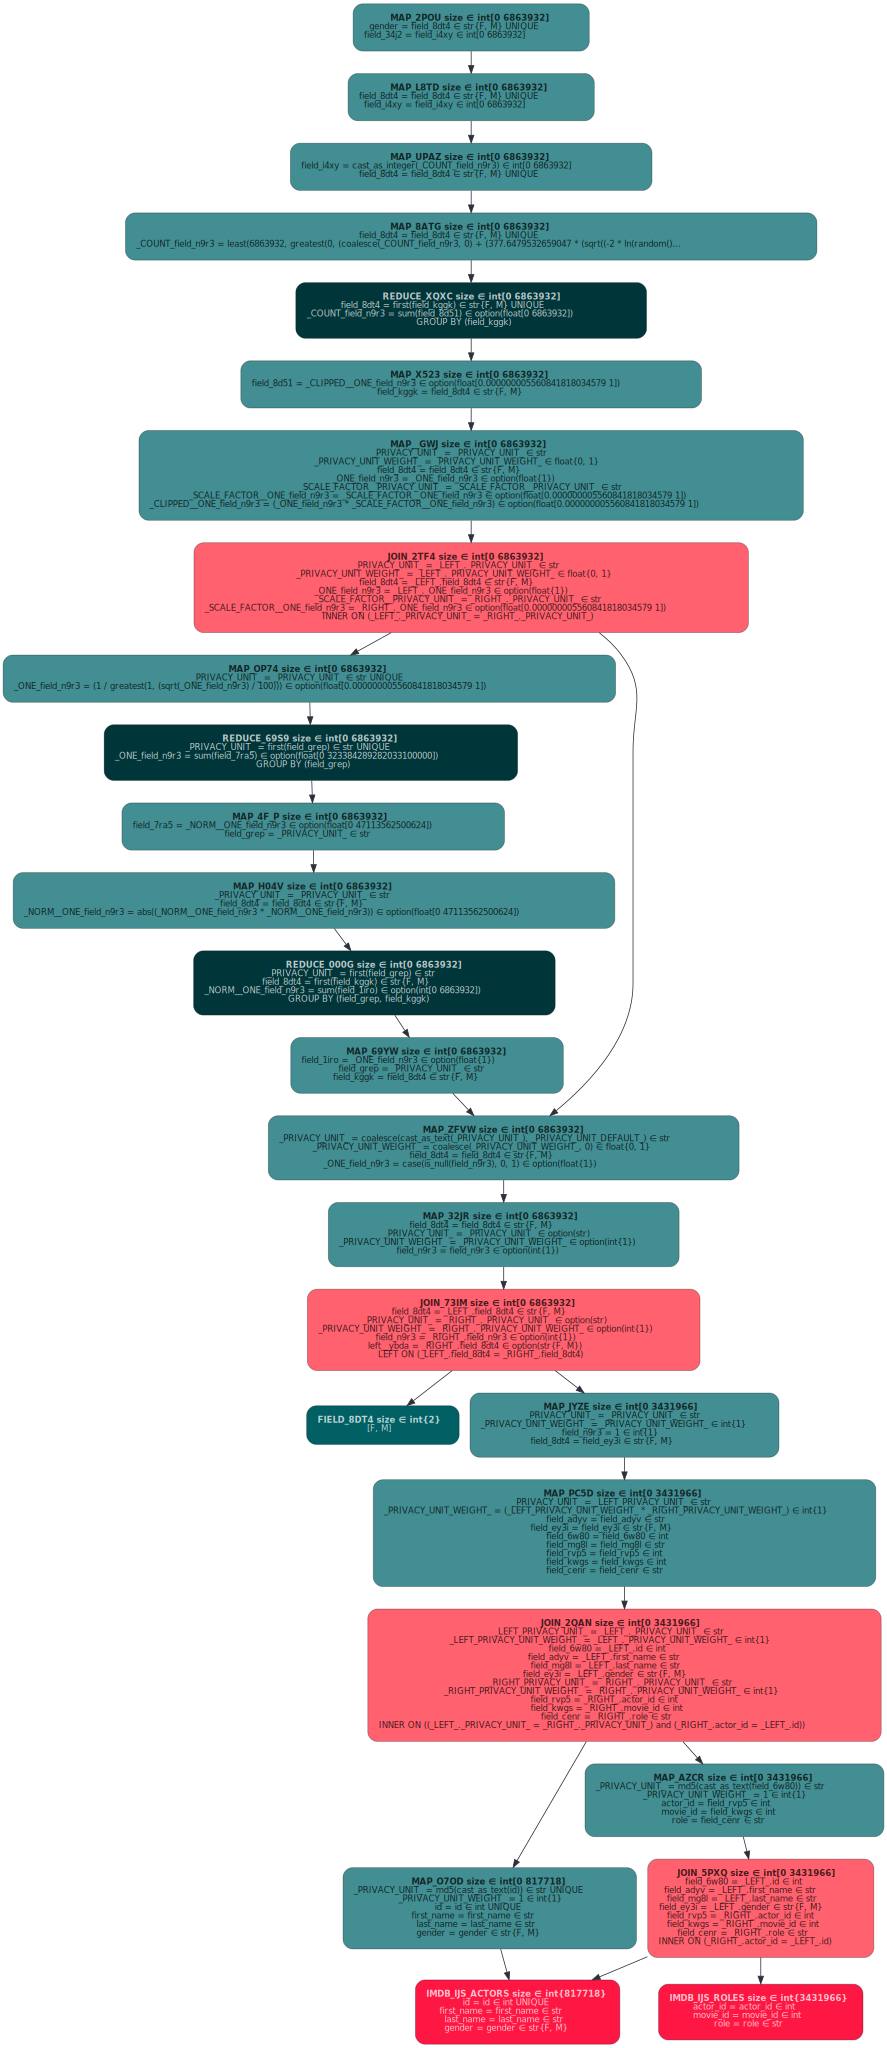

In [11]:
display(Source(dp_relation.dot()))

In [12]:
import pandas as pd

true_res = pd.read_sql(query, database.engine())
dp_res = pd.read_sql(dp_query, database.engine())

print('Result')
display(true_res.sort_values('gender'))

print('DP Result')
display(dp_res.sort_values('gender'))

Result


,gender,count
0,F,1135174
1,M,2296792


DP Result


,gender,field_34j2
1,F,1120217
0,M,2185869
